## Импорт библиотек

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, normaltest

## Импорт данных

In [ ]:
# Импортируем таблицу, где данные 5 компаний синхронизированы по дням
data = pd.read_excel('/content/drive/My Drive/Geekbrains/АВ тесты/DZ_8.xlsx', sheet_name='AB Test Results')
print(data.shape)
data.head(5)

(10000, 3)


/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [ ]:
print(data.dtypes)
data.tail(5)

USER_ID           int64
VARIANT_NAME     object
REVENUE         float64
dtype: object


,USER_ID,VARIANT_NAME,REVENUE
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0
9999,9468,control,0.0


In [ ]:
# Проверка на пропущенные значения (null)
missing_values = data.isnull().sum()

# Вывод информации о пропущенных значениях
print("Количество пропущенных значений по каждой колонке:")
print(missing_values)

Количество пропущенных значений по каждой колонке:
USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64


Пропусков в данных нет, можем переходить к EDA.

## Предварительный анализ

In [ ]:
variant_counts = data['VARIANT_NAME'].value_counts()
print(variant_counts)

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64


Как видим 2 группы разделены почти одинаково междуюзерами.

In [ ]:
revenue_stats = data['REVENUE'].describe()
print(revenue_stats)

count    10000.000000
mean         0.099447
std          2.318529
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        196.010000
Name: REVENUE, dtype: float64


In [ ]:
# Подсчет количества значений равных 0
count_zeros = (data['REVENUE'] == 0).sum()

# Подсчет количества ненулевых значений
count_non_zeros = (data['REVENUE'] != 0).sum()

print(f"Количество значений, равных 0: {count_zeros}")
print(f"Количество ненулевых значений: {count_non_zeros}")

Количество значений, равных 0: 9848
Количество ненулевых значений: 152


In [ ]:
# Фильтрация ненулевых значений
non_zero_values = data[data['REVENUE'] != 0]

# Сортировка значений
sorted_values = non_zero_values['REVENUE'].sort_values()

# Вывод статистики для отсортированных ненулевых значений
statistics = sorted_values.describe()
print(statistics)

count    152.000000
mean       6.542566
std       17.706752
min        0.020000
25%        1.250000
50%        2.420000
75%        4.607500
max      196.010000
Name: REVENUE, dtype: float64


Очень низкое среднее значение, достаточно больое стандартное отклонение, и есть выборсы.

## EDA

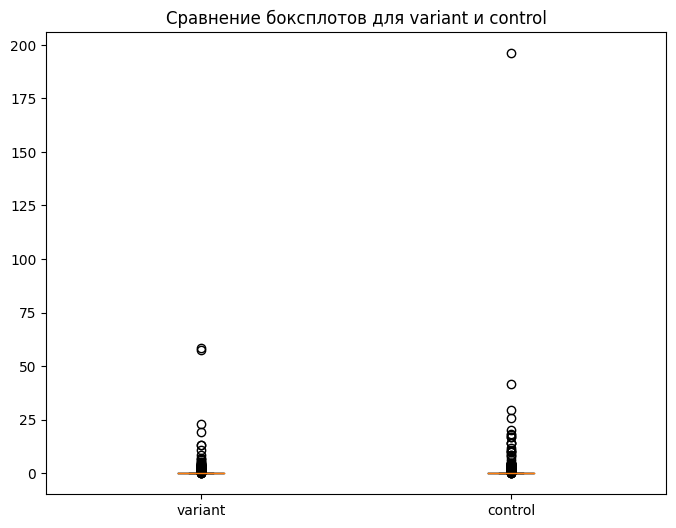

In [ ]:
data_variant = data[data['VARIANT_NAME'] == 'variant']
data_control = data[data['VARIANT_NAME'] == 'control']

plt.figure(figsize=(8, 6))
plt.boxplot([data_variant['REVENUE'], data_control['REVENUE']], labels=['variant', 'control'])
plt.title('Сравнение боксплотов для variant и control')

plt.show()


Не особо информативно, посмотрим только на ненулевые значения.

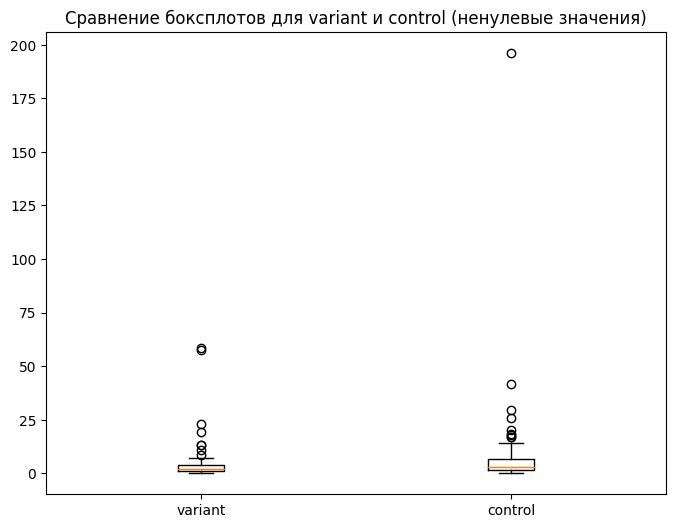

In [ ]:
data_variant = data[(data['VARIANT_NAME'] == 'variant') & (data['REVENUE'] > 0)]
data_control = data[(data['VARIANT_NAME'] == 'control') & (data['REVENUE'] > 0)]

plt.figure(figsize=(8, 6))
plt.boxplot([data_variant['REVENUE'], data_control['REVENUE']], labels=['variant', 'control'])
plt.title('Сравнение боксплотов для variant и control (ненулевые значения)')

plt.show()

Уже лучше, но ещё обрежем выбросы.

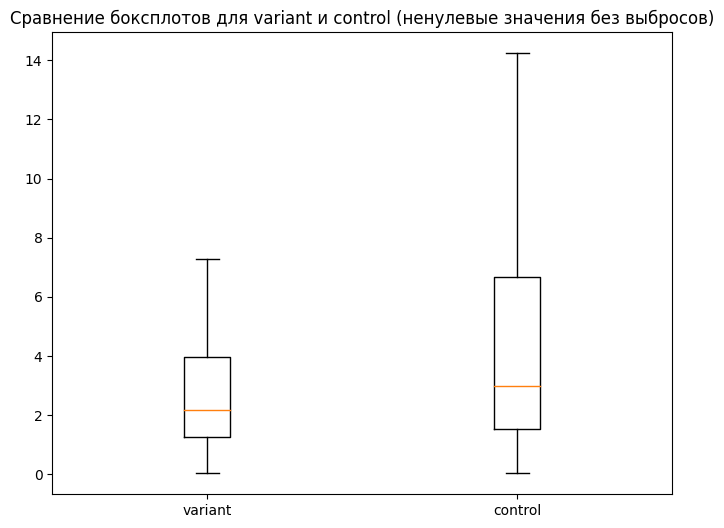

In [ ]:
data_variant = data[(data['VARIANT_NAME'] == 'variant') & (data['REVENUE'] > 0)]
data_control = data[(data['VARIANT_NAME'] == 'control') & (data['REVENUE'] > 0)]

plt.figure(figsize=(8, 6))
plt.boxplot([data_variant['REVENUE'], data_control['REVENUE']], labels=['variant', 'control'], showfliers=False)
plt.title('Сравнение боксплотов для variant и control (ненулевые значения без выбросов)')

plt.show()

Уже намного лучше. Как видно по графике, средий доход немного выше в группе control. Также в ней длинее и доходней межквартильный размах и больше стандартное отклонение.

In [ ]:
# Для проверки равенства средних значений (используем t-тест)
t_stat, p_value = stats.ttest_ind(data_variant['REVENUE'], data_control['REVENUE'])
alpha = 0.05  # Уровень значимости

if p_value < alpha:
    print(f'p-value: {p_value}, Отвергаем нулевую гипотезу. Средние значения различаются.')
else:
    print(f'p-value: {p_value}, Нет оснований отвергать нулевую гипотезу. Средние значения схожи.')

p-value: 0.27398955098678834, Нет оснований отвергать нулевую гипотезу. Средние значения схожи.


In [ ]:
# Для проверки равенства дисперсий (используем тест Бартлетта)
bartlett_stat, bartlett_p = stats.bartlett(data_variant['REVENUE'], data_control['REVENUE'])

alpha = 0.05  # Уровень значимости

if bartlett_p < alpha:
    print(f'p-value (Bartlett test): {bartlett_p}, Отвергаем нулевую гипотезу. Дисперсии различаются.')
else:
    print(f'p-value (Bartlett test): {bartlett_p}, Нет оснований отвергать нулевую гипотезу. Дисперсии схожи.')

p-value (Bartlett test): 3.24578862604794e-11, Отвергаем нулевую гипотезу. Дисперсии различаются.


С помощью статистических критериев подвтердили, что среднии почти равны, а дисперсии различны.

Для исследования плотности распределения построим графики-виоланчели, которые являются чем-то вроде симбиоза боксплота и гистограммы.

Shapiro-Wilk test for Variant (p-value): 0.0013381581520661712
Shapiro-Wilk test for Control (p-value): 1.3305504253935396e-08
Pearson test for Variant (p-value): 0.012352372006203602
Pearson test for Control (p-value): 1.1540163829478953e-06

Количество значений Variant: 64
Количество значений Control: 71


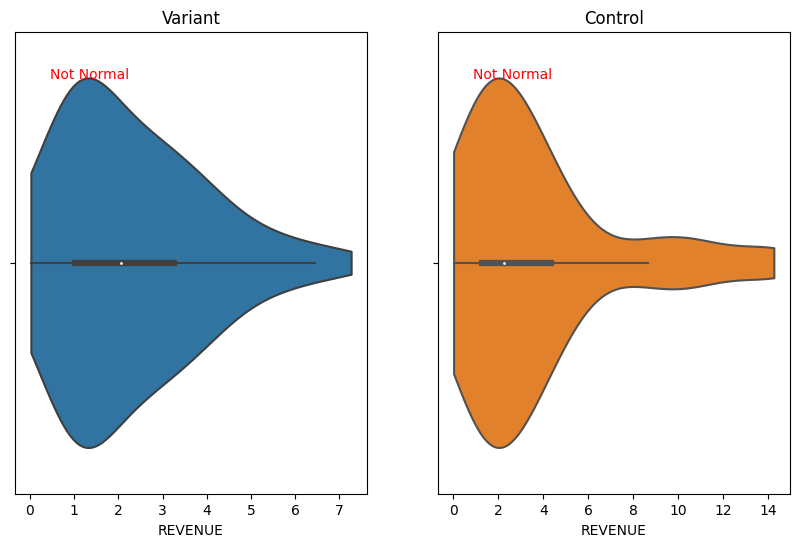

In [ ]:
# Определяем IQR для variant и control
Q1_variant = data_variant['REVENUE'].quantile(0.25)
Q3_variant = data_variant['REVENUE'].quantile(0.75)
IQR_variant = Q3_variant - Q1_variant

Q1_control = data_control['REVENUE'].quantile(0.25)
Q3_control = data_control['REVENUE'].quantile(0.75)
IQR_control = Q3_control - Q1_control

# Определяем верхний и нижний пределы для определения выбросов
lower_bound_variant = Q1_variant - 1.5 * IQR_variant
upper_bound_variant = Q3_variant + 1.5 * IQR_variant

lower_bound_control = Q1_control - 1.5 * IQR_control
upper_bound_control = Q3_control + 1.5 * IQR_control

# Удаляем выбросы
data_variant_no_outliers = data_variant[(data_variant['REVENUE'] >= lower_bound_variant) & (data_variant['REVENUE'] <= upper_bound_variant)]
data_control_no_outliers = data_control[(data_control['REVENUE'] >= lower_bound_control) & (data_control['REVENUE'] <= upper_bound_control)]

# Проводим тест Шапиро-Уилка и тест Д'Агостино и Пирсона для variant и control
shapiro_variant = shapiro(data_variant_no_outliers['REVENUE'])
shapiro_control = shapiro(data_control_no_outliers['REVENUE'])
normaltest_variant = normaltest(data_variant_no_outliers['REVENUE'])
normaltest_control = normaltest(data_control_no_outliers['REVENUE'])

print(f'Shapiro-Wilk test for Variant (p-value): {shapiro_variant[1]}')
print(f'Shapiro-Wilk test for Control (p-value): {shapiro_control[1]}')
print(f'Pearson test for Variant (p-value): {normaltest_variant[1]}')
print(f'Pearson test for Control (p-value): {normaltest_control[1]}')
print()

count_variant = data_variant_no_outliers.shape[0]
count_control = data_control_no_outliers.shape[0]

print(f'Количество значений Variant: {count_variant}')
print(f'Количество значений Control: {count_control}')

plt.figure(figsize=(10, 6))

# График для VARIANT_NAME == 'variant'
plt.subplot(121)
sns.violinplot(x='REVENUE', data=data_variant_no_outliers, scale='width', cut=0)
plt.title('Variant')
if shapiro_variant[1] > 0.05 and normaltest_variant[1] > 0.05:
    plt.text(0.1, 0.9, 'Normal', transform=plt.gca().transAxes, color='green')
else:
    plt.text(0.1, 0.9, 'Not Normal', transform=plt.gca().transAxes, color='red')

# График для VARIANT_NAME == 'control'
plt.subplot(122)
sns.violinplot(x='REVENUE', data=data_control_no_outliers, scale='width', cut=0, color='C1')
plt.title('Control')
if shapiro_control[1] > 0.05 and normaltest_control[1] > 0.05:
    plt.text(0.1, 0.9, 'Normal', transform=plt.gca().transAxes, color='green')
else:
    plt.text(0.1, 0.9, 'Not Normal', transform=plt.gca().transAxes, color='red')

plt.show()


In [ ]:
print(data_variant_no_outliers.mean())
print(data_control_no_outliers.mean())

USER_ID    5273.468750
REVENUE       2.302656
dtype: float64
USER_ID    4647.690141
REVENUE       3.655352
dtype: float64


<ipython-input-64-525bf78312e2>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(data_variant_no_outliers.mean())
<ipython-input-64-525bf78312e2>:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(data_control_no_outliers.mean())


## Выводы

Более лучшим являются результаты группы Control.

* В ней выше конверсия.
* В ней больше высокодоходных клиентов, причём значительно.

Совет: желательно ещё продалжать эксперимент или увеличить мощность тестовых групп, чтобы медианное значение в группе Control стало больше для большего различия с группой Variant.

Если результаты подвердятся ещё лучше, то вывести в продакшен для всех юзеров изменения, которые были сделаны в группе Control.